# Code 1: DQN with Experience Replay and Target Network

In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

在传统的 Q-learning 算法中，用表格存储动作价值的做法只在环境的状态和动作都是离散的，并且空间都比较小的情况下适用，我们之前进行代码实战的几个环境都是如此（如悬崖漫步）。
当状态或者动作数量非常大的时候，这种做法就不适用了。
对于这种情况，我们需要用函数拟合的方法来估计值，即将这个复杂的值表格视作数据，使用一个参数化的函数来拟合这些数据。我们今天要介绍的 DQN 算法便可以用来解决**连续状态下离散动作**的问题。

以图中所示的所示的车杆（CartPole）环境为例，它的状态值就是连续的，动作值是离散的。

![jupyter](./image/cartpole.gif)

现在我们想在类似车杆的环境中得到动作价值函数，由于状态每一维度的值都是连续的，无法使用表格记录，因此一个常见的解决方法便是使用函数拟合（function approximation）的思想。
由于神经网络具有强大的表达能力，因此我们可以用一个神经网络来表示函数。
注意通常 DQN（以及 Q-learning）只能处理**动作离散**的情况，因为在函数的更新过程中有$max_a$这一操作。我们将用于拟合动作价值函数的神经网络称为 Q 网络，如图所示。

![jupyter](./image/dqn.png)

DQN算法的具体流程如下 (这里我们没有preprocess操作)：

<img src="./image/DQN_alg.webp" style="zoom:40%" />

首先定义经验回放池的类，主要包括加入数据 (增)、采样数据 (查) 两大函数。

In [2]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)    # 随机采样, list of tuple
        state, action, reward, next_state, done = zip(*transitions) # 将state, action, reward, next_state, done分别存放
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

我们采用的测试环境是 CartPole-v0，其状态空间相对简单，只有 4 个变量，因此网络结构的设计也相对简单：采用一层 128 个神经元的全连接并以 ReLU 作为激活函数。当遇到更复杂的诸如以图像作为输入的环境时，我们可以考虑采用深度卷积神经网络。

In [3]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        # state_dim --> hidden_dim --> action_dim

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

有了这些基本组件之后，接来下开始实现 DQN 算法，主要是take_action和update

In [4]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作 (off-policy)
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)    # (batch_size, state_dim)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)    # (batch_size, 1)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)   # (batch_size, 1)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)   # (batch_size, state_dim)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device) # (batch_size, 1)

        q_values = self.q_net(states).gather(1, actions)  # 当前状态采取action对应的Q值, (batch_size, 1)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)  # 下个状态的最大Q值, (batch_size, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones
                                                                )  # TD误差目标, (batch_size, 1)
                                                                
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [5]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0) # gym version 0.21.0
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print(f'state space: {env.observation_space}')
print(f'action space: {env.action_space}')

agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset() # gym version 0.21.0
            # state, _ = env.reset(seed=0,)   # gym version 0.26.2
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)  # gym version 0.21.0
                # next_state, reward, done, _, _ = env.step(action)   # gym version 0.26.2
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)   # 游戏没有结束时，就可以更新Q网络
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

# 2m on one NVIDIA 4060 GPU

state space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_8014/215906700.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402374358/work/torch/csrc/utils/tensor_new.cpp:245.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:13<00:00,  3.82it/s, episode=500, return=200.000]


In [6]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

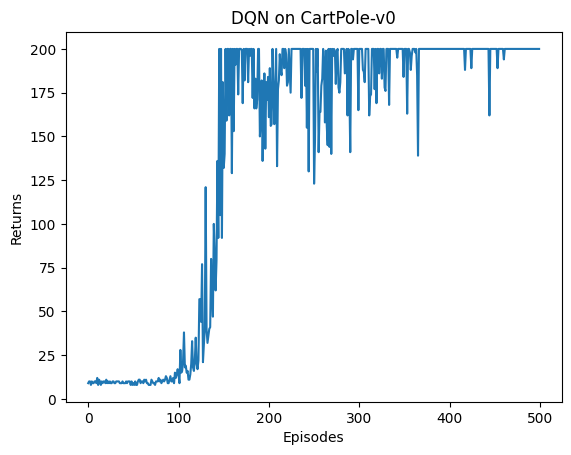

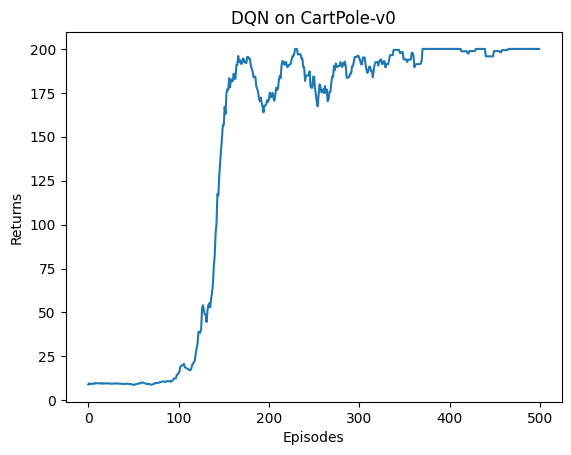

In [7]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

可以看到，DQN 的性能在 100 个序列后很快得到提升，最终收敛到策略的最优回报值 200 (gym version 0.21.0)。我们也可以看到，在 DQN 的性能得到提升后，它会持续出现一定程度的震荡，这主要是神经网络过拟合到一些局部经验数据后由运算带来的影响。

Credit: https://hrl.boyuai.com/chapter/2/dqn%E7%AE%97%E6%B3%95